In [33]:
%matplotlib inline

In [34]:
from __future__ import division
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 25)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 1024)

In [35]:
#wget http://www.mathstat.strath.ac.uk/outreach/nessie/datasets/whiskies.txt
df = pd.read_csv('whiskies.txt')
df.head(1)

,RowID,Distillery,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral,Postcode,Latitude,Longitude
0,1,Aberfeldy,2,2,2,0,0,2,1,2,2,2,2,2,\tPH15 2EB,286580,749680


In [36]:
import sklearn.datasets
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.preprocessing import StandardScaler
X = df.drop(['RowID', 'Distillery', 'Postcode', ' Latitude', ' Longitude'], axis=1)
X.describe()

# X_std = StandardScaler().fit_transform(X)
# pd.DataFrame(X_std, columns=X.columns).describe()
n_components = 5
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
X.shape, X_pca.shape
weights = np.round(pca.components_, 3)
ev = np.round(pca.explained_variance_ratio_, 3)
ev

pca_df = pd.DataFrame(weights, columns=X.columns)
pca_df

import warnings
warnings.simplefilter(action = "ignore")
component_names = []
pca_df_t = pca_df.T
for col in pca_df_t:
    component = pca_df_t[col]
    order = component.abs()#.order(ascending=False)
    top = order.head(3)
    component_name = [name if component[name] > 0 else ('neg-' + name) for name in top.index]
    component_names.append('/'.join(component_name))

pca_df.index = component_names
pca_df

,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral
Body/neg-Sweetness/Smoky,0.361,-0.203,0.478,0.575,0.092,-0.221,0.058,-0.037,-0.048,-0.128,-0.202,-0.384
Body/Sweetness/Smoky,0.491,0.047,0.069,-0.161,-0.020,0.418,0.175,0.640,0.260,0.103,0.124,-0.131
neg-Body/Sweetness/neg-Smoky,-0.030,0.264,-0.219,-0.043,0.001,-0.110,-0.699,0.233,0.179,-0.108,-0.403,-0.343
Body/Sweetness/neg-Smoky,0.075,0.371,-0.089,-0.082,0.033,-0.033,0.172,0.226,-0.851,-0.072,-0.095,-0.149
neg-Body/neg-Sweetness/Smoky,-0.227,-0.009,0.202,0.033,0.009,0.597,0.134,-0.111,-0.025,0.105,-0.703,0.120


2    39
0    28
1    13
3     6
Name: cluster, dtype: int64

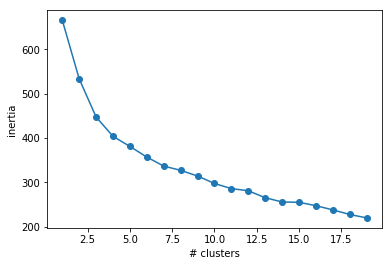

In [37]:
inertia = [np.NaN]
for i in range(1,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    
ax = plt.subplot(111)
ax.plot(inertia, 'o-')
ax.set_ylabel('inertia')
ax.set_xlabel('# clusters')

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)

X['cluster'] = kmeans.labels_

X.cluster.value_counts()

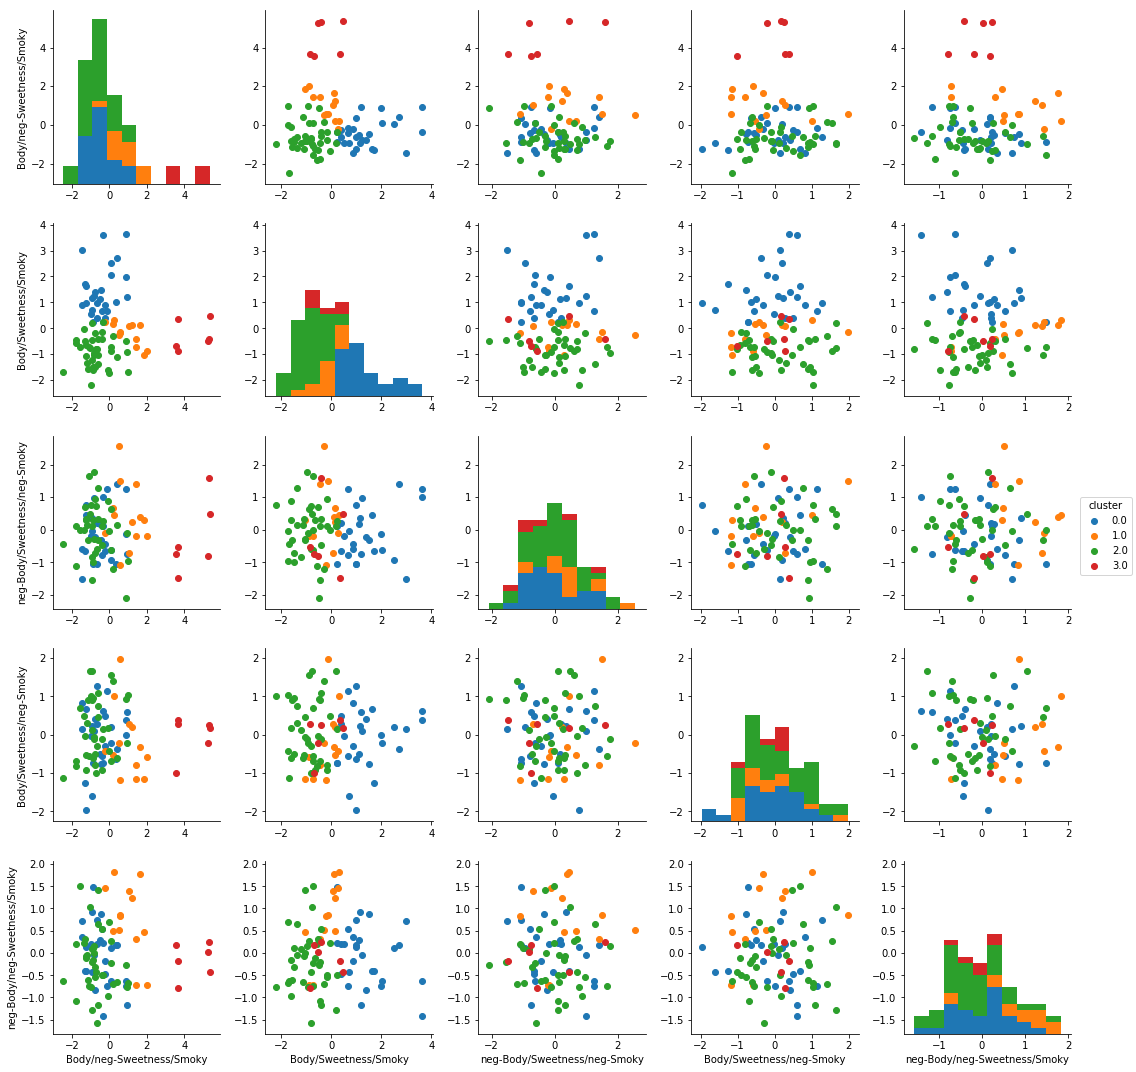

In [38]:
X_pca_clustered = np.insert(X_pca, n_components, values=kmeans.labels_, axis=1)

pca_cluster_df = pd.DataFrame(X_pca_clustered, columns=component_names + ['cluster'])

g = sns.PairGrid(pca_cluster_df, hue='cluster', vars=component_names, size=3)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

In [39]:
dist = sklearn.metrics.pairwise.euclidean_distances(X)

sim = sklearn.metrics.pairwise.cosine_similarity(X)

dist_df = pd.DataFrame(dist, columns=df.Distillery, index=df.Distillery)

sim_df = pd.DataFrame(sim, columns=df.Distillery, index=df.Distillery)

cluster_s = X.cluster
cluster_s.index = df.Distillery

sim_df['Ardbeg']#.order(ascending=False)

features_df = df.ix[:,1:13].set_index('Distillery')

In [40]:
#Add the cluster info to the features DataFrame so we only have to persist one file for both.

features_df['cluster'] = cluster_s

features_df.to_pickle('features.dataframe')

sim_df.to_pickle('sims.dataframe')